In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error 
import composition
import utils

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR

In [3]:
df = pd.read_csv("/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/Material_Properties/materials.csv")
df.head()

,ENTRY,AEL VRH bulk modulus,AEL elastic anisotropy,AEL Poisson ratio,AEL VRH shear modulus,space group,Pearson symbol,DATA
0,Ag10S8Sb2 [d3aa24a7307877b5],35.2376,0.440193,0.350433,11.7082,36 - Cmc21,oS40,"[API, Out, JSON ]"
1,Ag1Al1S2 [e81fdf58728bbeef],71.6539,1.125370,0.302537,32.5879,156 - P3m1,hP4,"[API, Out, JSON ]"
2,Ag1C2K1 [30b4ea4c8457fd17],27.2627,21.340800,0.289897,13.3219,123 - P4/mmm,tP4,"[API, Out, JSON ]"
3,Ag1C2Li1 [4038910d534b860e],36.3669,21.700800,0.297220,17.0545,187 - P6m2,hP4,"[API, Out, JSON ]"
4,Ag1In5Se8 [59aa7f06d2a88d1a],24.7673,1.487440,0.274498,13.1466,111 - P42m,tP14,"[API, Out, JSON ]"


In [4]:
# Step 1: Data Preprocessing (Encapsulate in a function)

uncleaned_formulae = df['ENTRY ']
cleaned_formulae = []
for value in uncleaned_formulae:
    #split string into list
    split_list = value.split(" [")
    clean_formula = split_list[0]
    cleaned_formulae.append(clean_formula)
#Lets now create a new dataframe to hold the clean data 
df_cleaned = pd.DataFrame()

#adding columns to the DF
df_cleaned['formula'] = cleaned_formulae

#adding a column with the target property we want to predict
#Here I am targeting to predict bulk modulus of the material
df_cleaned['bulk_modulus'] = df['AEL VRH bulk modulus ']

In [5]:
check_for_duplicates = df_cleaned['formula'].value_counts()
df_cleaned.drop_duplicates('formula', keep='first', inplace=True)

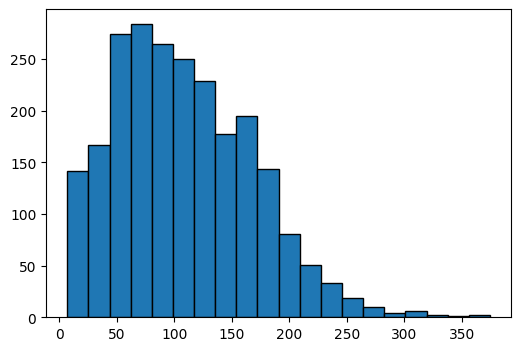

In [6]:
plt.figure(figsize=(6,4))
df_cleaned['bulk_modulus'].hist(bins=20, grid=False, edgecolor = 'black')
plt.show()

In [7]:
#Rename columns to match the required input
df_cleaned.columns = ['formula', 'target']

#Lets convert our chemical formula into features
X, y, formulae = composition.generate_features(df_cleaned)

The element: Pu from formula C8Pu4W4 is not currently supported in our database


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
scalar = StandardScaler()
normalizer = Normalizer()
# Do the scaling step
X_train_scaled = scalar.fit_transform(X_train)  # get statistics & transform
X_test_scaled = scalar.transform(X_test)  # transform using 'training' stats.
# Do the normalizing step
X_train_scaled = normalizer.fit_transform(X_train_scaled)  # normalize vectors
X_test_scaled = normalizer.transform(X_test_scaled)  # normalize vectors

In [13]:
models = {
    'Linear Regression': (Lasso(), {'alpha': np.logspace(-3, 1, 5)}),
    'K-Nearest Neighbour': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [5, 10, 15]}),
    'Support Vector Machine': (SVR(), {'C': np.logspace(-2, 3, 6), 'epsilon': [0.01, 0.1, 1], 'gamma': np.logspace(-2, 2, 5)}),
    'Random Forest Regressor': (RandomForestRegressor(), {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, 20]}),
    'Gradient Boosting Regressor': (GradientBoostingRegressor(), {'n_estimators': [50, 100, 150], 'max_features': [0.5, 0.75, 1.0]})
}

best_model = None
best_score = -np.inf
cv = KFold(n_splits=5, shuffle=True, random_state=1)

In [14]:
for model_name, (model, param_grid) in models.items():
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='r2')
    grid.fit(X_train_scaled, y_train)
    y_test_pred = grid.predict(X_test_scaled)
    score = r2_score(y_test, y_test_pred)
    
    print(f"{model_name} - Best R2 score: {score:.3f} with parameters: {grid.best_params_}")
    
    if score > best_score:
        best_score = score
        best_model = grid.best_estimator_

print(f"Best model: {best_model} with R2 score: {best_score:.3f}")

/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.525e+04, tolerance: 4.434e+02
  model = cd_fast.enet_coordinate_descent(
/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+05, tolerance: 4.445e+02
  model = cd_fast.enet_coordinate_descent(
/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to 

Linear Regression - Best R2 score: 0.881 with parameters: {'alpha': 0.001}
K-Nearest Neighbour - Best R2 score: 0.826 with parameters: {'n_neighbors': 5}
Decision Tree - Best R2 score: 0.794 with parameters: {'max_depth': 10}
Support Vector Machine - Best R2 score: 0.920 with parameters: {'C': 100.0, 'epsilon': 1, 'gamma': 1.0}
Random Forest Regressor - Best R2 score: 0.899 with parameters: {'max_depth': 20, 'n_estimators': 50}
Gradient Boosting Regressor - Best R2 score: 0.903 with parameters: {'max_features': 0.5, 'n_estimators': 150}
Best model: SVR(C=100.0, epsilon=1, gamma=1.0) with R2 score: 0.920
